This is a sketchbook for the design of an `@dist` DSL for GenJAX. The inversion + ILDJ functionality comes from [Oryx][oryx] (hence the title, `coryx = core Oryx`).

[oryx]: https://github.com/jax-ml/oryx

In [1]:
import genjax
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

console = genjax.pretty()
key = jax.random.PRNGKey(0)

Inversion works for functions with known inverses like `exp`, as well as addition when one of the elements is a constant.

[This example is from the Oryx docs.][oryx_docs]

[oryx_docs]: https://www.tensorflow.org/probability/oryx/notebooks/a_tour_of_oryx?_gl=1*17ywian*_ga*MTQwMzU0NDQ2LjE2Njg3MDM0NTQ.*_ga_W0YLR4190T*MTY3NjQwNTUzNi40Mi4wLjE2NzY0MDU1MzYuMC4wLjA.

In [2]:
@genjax.dist
def new_dist(x, z):
    v = genjax.rv(genjax.Normal)(x, z)
    return jnp.exp(v / 2.0) + 2.0

In [3]:
# I can sample from `new_dist`.
v = new_dist.sample(key, 0.0, 2.0)

# I can score a return value.
q = new_dist.logpdf(3.0, 0.0, 2.0)
(v, q)

(Array(2.2860641, dtype=float32), Array(-0.71319103, dtype=float32))

In [4]:
# Recreates the Oryx example.
def show_plot(mean, std):
    vs = jit(vmap(new_dist.sample, in_axes=(0, None, None)))(
        jax.random.split(jax.random.PRNGKey(0), 1000), mean, std
    )
    x = jnp.linspace(0.0, 8, 100)
    scores = jnp.exp(jit(vmap(new_dist.logpdf, in_axes=(0, None, None)))(x, mean, std))
    _, ax = plt.subplots(2, sharex=True)
    ax[0].hist(vs, bins="auto")
    ax[1].plot(x, scores)
    plt.show()

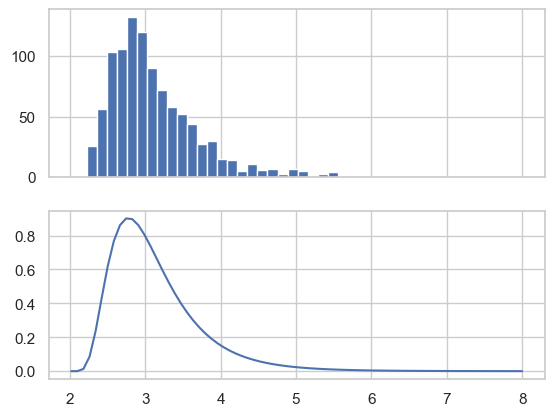

In [5]:
show_plot(0.0, 1.0)

## Labeled Categorical

Invertible deterministic transforms should support relabeling when the label array has unique elements (and has #. elements equal to the cardinality of the event space).

In [17]:
labels = jnp.array([1.0, 0.0])


@genjax.dist
def labeled_categorical(labels, logits):
    v = genjax.rv(genjax.TFPCategorical)(logits)
    return labels[v]

In [18]:
# Sampling forward is okay.
key = jax.random.PRNGKey(0)
logits = jnp.array([0.3, 0.7])
v = labeled_categorical.sample(key, labels, logits)
v

Array(1., dtype=float32)

In [21]:
# Inversion currently breaks.
score = labeled_categorical.logpdf(0.0, labels, logits)
score

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/mk/btkplz1n40q001dsy957srbh0000gn/T/ipykernel_1989/4195692211.py:2 in <module>      │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/mk/btkplz1n40q001dsy957srbh0000gn/T/ipykernel_1989/4195692211.py'                  │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/generative_functions/distributions/coryx/lang │
│ .py:192 in logpdf                                                                                │
│                                                                                                  │
│   189 │   │   def scorer(constraints):                                                           │
│   190 │   │   │   return sow_transform(self.source, constraints)(*args)[1]                       │
│   191 │   │                                                                                      │
│ ❱ 192 │   │   inverses, ildj_correction = inverse_core.inverse_and_ildj(returner)(v)             │
│   193 │   │   score = scorer(inverses) + ildj_correction                                         │
│   194 │   │   return score                                                                       │
│   195                                                                                            │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/generative_functions/distributions/coryx/core │
│ .py:163 in wrapped                                                                               │
│                                                                                                  │
│   160 │   def wrapped(*args, **kwargs):                                                          │
│   161 │   │   """Function wrapper that takes in inverse arguments."""                            │
│   162 │   │   forward_args = trace_args if len(trace_args) else args                             │
│ ❱ 163 │   │   jaxpr, (_, in_tree, _) = trace_util.stage(f, dynamic=False)(                       │
│   164 │   │   │   *forward_args, **kwargs                                                        │
│   165 │   │   )                                                                                  │
│   166 │   │   flat_forward_args, _ = tree_util.tree_flatten(forward_args)                        │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/src/genjax/_src/core/staging.py:64 in wrapped                 │
│                                                                                                  │
│    61 │   │   │   jaxpr, _, consts = pe.trace_to_jaxpr_dynamic(flat_fun, flat_avals)             │
│    62 │   │   else:                                                                              │
│    63 │   │   │   pvals = [pe.PartialVal.unknown(aval) for aval in flat_avals]                   │
│ ❱  64 │   │   │   jaxpr, _, consts = pe.trace_to_jaxpr(flat_fun, pvals, instantiate=True)        │
│    65 │   │   typed_jaxpr = jax_core.ClosedJaxpr(jaxpr, consts)                                  │
│    66 │   │   return typed_jaxpr, (flat_args, in_tree, out_tree())                               │
│    67                                                                                            │
│                                                                                                  │
│ /Users/mccoybecker/research/genjax/.nox/jupyter/lib/python3.11/site-packages/jax/_src/profiler.p │
│ y:314 in wrapper                                           

## Inversion on edge cases

In [ ]:
@genjax.dist
def edge_0(x):
    v = genjax.rv(genjax.Normal)(x, 1.0)
    q = genjax.rv(genjax.Normal)(x, 1.0)
    return (v, v - q)

In [ ]:
# Sampling forward is okay.
key = jax.random.PRNGKey(0)
v = edge_0.sample(key, 0.0)
v

In [ ]:
# Inversion currently breaks.
score = edge_0.logpdf((0.3, 0.2), 1.0)
score

## Programs which should fail

In [ ]:
@genjax.dist
def new_dist(x):
    v = genjax.rv(genjax.Normal)(x, 1.0)
    return jnp.cos(v), jnp.sin(v)

In [ ]:
# Sampling forward is okay.
key = jax.random.PRNGKey(0)
v = new_dist.sample(key, 1.0)
v

In [ ]:
# Inversion should break.
key = jax.random.PRNGKey(314159)
score = new_dist.logpdf(v, 1.0)
score